(sec-fourier)=
# Spectral Analysis and Synthesis

>L’étude profonde de la nature est la source la plus féconde de découvertes mathématiques. -- Jean-Baptiste Joseph Fourier (1768–1830)

Given a signal $y(t)$ of a played piano key, how can we compute the pitch and how can we recreate that sound?
Spectral analysis and synthesis gives us some answers.
By *transforming* the representation of a signal, it catapultes from the space of amplitude over into the space of intensity over frequencies.

Spectral analysis works with two representations of sound:

1. **Inverse Fourier transform**: a signal in the time domain $y(t)$
2. **Fourier transform**: a signal in the frequency domain $Y(f)$

But before we start, let us discuss the immense importance of the Fourier transform and its inverse counterpart.

## Introduction

In mathematics, the meaning of *transform* and *transformation* is somewhat specific, but it still is rather wide or loose, when the definition sometimes found says it is a mathematical quantity obtained from a given quality by an algebraic, geometric, or functional operation.
In *transform theory*, mathematicians talk about a suitable choice of a function, called *kernel* (from the German *nucleus* or *core*), by which a problem may be simplified.
In 1822 *Jean-Baptise Joseph Fourier* discovered a truely remarkalbe *transformation* which gives us insights to our knowledge of waveforms in general and music in particular.

He claimed that any function, whether continuous or discontinuous, can be expanded into a series of sines.
That important work was corrected to

>Almost any periodic function can be represented by a Fourier series that converges.

and expanded upon by others to provide the foundation for various forms of the Fourier transform used since.

I find this result still fascinating.
At this point I have to mention that the great German mathematician *Carl Friedrich Gauß* already discovered this connection in 1805 and, what is even more remarkable, he formulated something quite similar as the *fast Fourier transform (FFT)*!
The reason his breakthrough was not widely adopted was because it only appeared after his death in volume three of his collected works and it was written with non-standard notation in a 19th century version of Latin. 

Especially since the re-discovery of the *fast Fourier transformation (FFT)* in 1965 by *Cooley* and *Tukey* to detect underground tests of atmoic bombs, the Fourier synthesis is a widespread technique performed in all areas of signal processing.
There are so many applications of the FFT, from solving differential equations to radar and sonar, studying crystal structures, WiFi and 5G.
It is no surprise that the mathematician *Gilbert Strang* called the FFT

>The most important numerical algorithm of our lifetime. -- Gilbert Strang

But why is that?
Well, it is all about computation speed!
The *FFT* reduces the time complexity of the *Discrete Fourier Transformation (DFT)* from $\mathcal{O}(n^2)$ to $\mathcal{O}(n\log(n))$ which makes the computation of the *DFT* fast thus applicable for many areas and purposes.

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
from scipy.integrate import cumtrapz

dpi = 300
transparent = True
PI = np.pi
TWO_PI = 2*PI
NUM = 44000
show = False

sns.set_theme('talk')
sns.set_style("whitegrid")

def lineplot(x, y, filename=None, title=None, xlim=None, ylim=None, ax=None, fig=None, **kargs):
    if not ax or not fig:
        fig, ax = plt.subplots()
    ax.plot(x, y, **kargs)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if show:
        plt.show()
    if filename != None:
        fig.savefig(filename, bbox_inches='tight',
                    transparent=transparent, pad_inches=0, dpi=dpi)
    return fig, ax

## Fourier Series

The process of constructing a periodic function by a *Foruier series* is called *Fourier synthesis*.

````{admonition} Fourier Series (FS)
:name: def-fourier-series
:class: definition
A *Fourier series* is a sum that represents a *periodic function* as a sum of *sine* and *cosine* waves.
The frequency of each wave in the sum is an integer multiple of the periodic function's fundamental frequency.
The *Foruier series* in amplitude-phase form $y_N(t)$ of a periodic function $y(t)$ is defined by

```{math}
:label: eq:fourier:series
y_N(t) = \frac{A_0}{2} + \sum\limits_{n=1}^N A_n \cdot \cos\left(\frac{2\pi \cdot n}{T}t - \phi_n\right)
```

where $N$ is potentially an infinite integer. 
$T$ is the period of $y(t)$, $A_n$ is the $n$-th hermonic's *amplitude* and $\phi_n$ is its *phase shift*.
$A_0/2$ is the DC component, it is the mean value of $y(t)$.
````

Except for pathological functions, any periodic function can be represented by a *Fourier series (FS)* that converges.
Convergence of *Fourier series* means that as more and more harmonics from the series are summed, each successive partial *Fourier series sum* will better approximate the function, and will equal the function with a potentially infinite number of harmonics.

```{admonition} Fourier Theorem
:name: theorem-fourier-synthesis
:class: theorem
Except for pathological functions, any periodic vibration, no matter how complicated it seems, can be built up from sinusoids whose frequencies are integer multiples of a fundamental frequency, by choosing the proper amplitudes and phases.
```

Non-periodic functions can be handled using an extension of the *Fourier series* called the *Fourier transform* which treats non-periodic functions as periodic with infinite period.
This transform thus can generate frequency domain representations of non-periodic functions as well as periodic functions, allowing a waveform to be converted between its time domain representation and its frequency domain representation.

In section [Additive Synthesis](sec-additive-synthesis) we use *Fourier synthesis* to construct complicated waveforms from a sum of simple sinusoids, i.e., a *Fourier series*.
For example, the (periodic) [sawtooth wave](sec-sawtooth-wave)

```{math}
    y_\text{saw}(t) = A \cdot 2 \left( f \cdot t -  \left \lfloor{ \frac{1}{2} + f \cdot t} \right \rfloor  \right),
```

can be constructed by an infinite sum

```{math}
    y_\text{saw}(t) = A \left( \frac{1}{2} - \frac{1}{\pi} \sum_{k=1}^{\infty} (-1)^k \frac{\sin(2\pi k f t)}{k} \right).
```

(sec-similarity-of-functions)=
## Similarity of Periodic Functions

Let us start from the assumption that the *Fourier Theorem* is correct (which it is) and let us consider a periodic function $y(t)$ and its *Fourier series (FS)* $y_N(t)$, see Eq. {eq}`eq:fourier:series`.
Than the question is: how can we compute all these amplitudes $A_n$ and phase shifts of the respective frequency?

$y_N(t)$ is a superposition of *sinusoidals* and we basically ask: how much of a specific sinusoidal is in $y(t)$.
Therefore, computing *sinusoidals* that are similar to $y(t)$ seems to be a good starting point.
Instead of similarity one speaks of *cross-correlation* which is a measure of similarity of two series as a function of the displacement of one relative to the other, also known as *sliding dot product* or *sliding inner-product*.

Functions are similar if their product result in a positive function.
In other words, if the integral of their product is positive.

In the following plot we can see this intuition at work.
The integral of $\sin(2\pi t)$ gives us $0.5$, i.e., there is alot of $\sin(2\pi t)$ in $\sin(2\pi t)$.
We also get a positive value for the integral of $\sin(2\pi t)$ multiplied with [sawtooth wave](sec-sawtooth-wave).
The integrals of the other products are zero.

```isc
( // generate the y(t) * sin(2*pi*u)
{[
    SinOsc.ar(1) * SinOsc.ar(1), 
    LFSaw.ar(1) * SinOsc.ar(1),
    SinOsc.ar(1) * SinOsc.ar(1,0.5*pi),
    LFTri.ar(0.5)*(-1)*SinOsc.ar(1)
]}.plot(1)
)
```

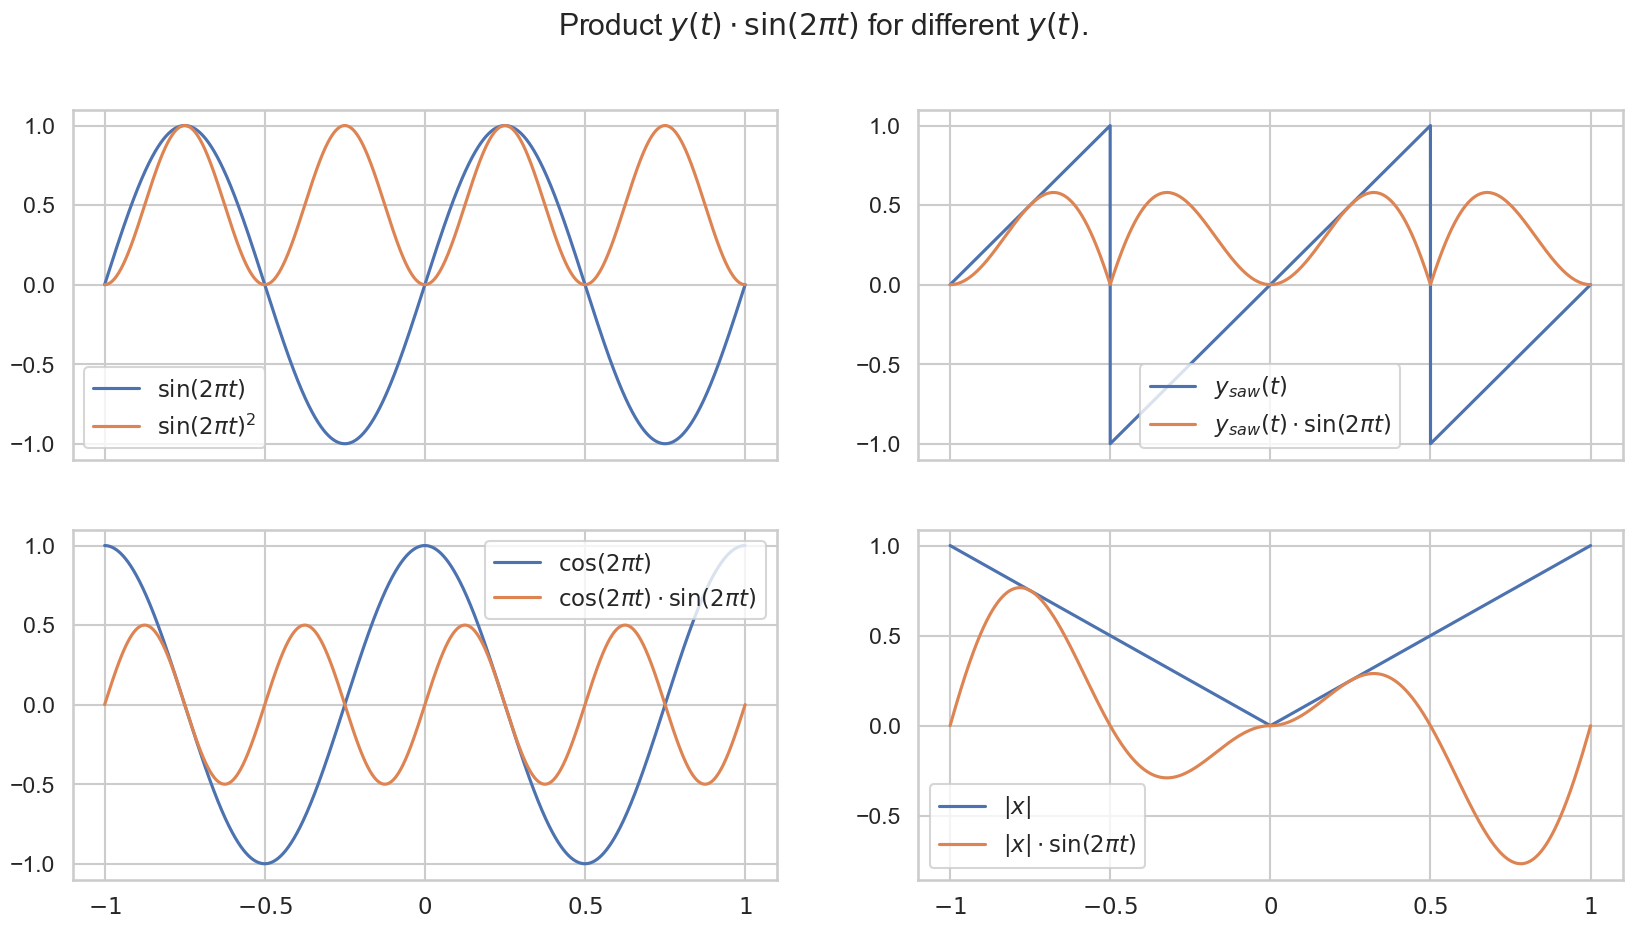

In [2]:
N = 10000
x = np.linspace(-1, 1, N)
y = lambda x: np.sin(x)*np.sin(x)

fig, ax = plt.subplots(2,2,figsize=(20,10))

# sin, sin^2
ax[0,0].set_xticks(np.arange(-1, 1+0.01, 0.5))
ax[0,0].set_xticklabels([])
ax[0,0].plot(x, np.sin(2*np.pi*x), label=r'$\sin(2\pi t)$')
ax[0,0].plot(x, np.sin(2*np.pi*x)*np.sin(2*np.pi*x), label=r'$\sin(2\pi t)^2$')
ax[0,0].legend()

ax[0,1].set_xticks(np.arange(-1, 1+0.01, 0.5))
ax[0,1].set_xticklabels([])
saw = lambda x: 2 * (x - np.floor(1/2 + x))
ax[0,1].plot(x, saw(x), label=r'$y_{saw}(t)$')
ax[0,1].plot(x, np.sin(2*np.pi*x)*saw(x), label=r'$y_{saw}(t) \cdot \sin(2\pi t)$')
ax[0,1].legend()

ax[1,0].set_xticks(np.arange(-1, 1+0.01, 0.5))
ax[1,0].set_xticklabels([r'$-1$', r'$-0.5$', r'$0$', r'$0.5$', r'$1$'])
ax[1,0].plot(x, np.cos(2*np.pi*x), label=r'$\cos(2\pi t)$')
ax[1,0].plot(x, np.sin(2*np.pi*x)*np.cos(2*np.pi*x), label=r'$\cos(2\pi t) \cdot \sin(2\pi t)$')
ax[1,0].legend()

ax[1,1].set_xticks(np.arange(-1, 1+0.01, 0.5))
ax[1,1].set_xticklabels([r'$-1$', r'$-0.5$', r'$0$', r'$0.5$', r'$1$'])
saw = lambda x: np.abs(x)
ax[1,1].plot(x, saw(x), label=r'$|x|$')
ax[1,1].plot(x, np.sin(2*np.pi*x)*saw(x), label=r'$|x| \cdot \sin(2\pi t)$')
ax[1,1].legend()
txt = fig.suptitle(r'Product $y(t) \cdot \sin(2\pi t)$ for different $y(t)$.')

Let's have a look at the sum of the first terms of the [sawtooth wave](sec-sawtooth-wave):

$$y(t) = \sum_{k=1}^8 \frac{1}{k}\sin(2\pi \cdot k \cdot t).$$

For shorthand let us also define the product with a sine wave of a certain frequency of $n \in \mathbb{N}$ Hz:

$$g_n(t) = y(t) \cdot \sin(2\pi \cdot n \cdot t).$$

```isc
({
    var sines = Array.fill(8, {arg i; 1/(i+1) * SinOsc.ar(i+1);});
    var y = Mix(sines);
    [y]++Array.fill(8, {arg i; y*SinOsc.ar(i+1)});
}.plot(1)
)
```

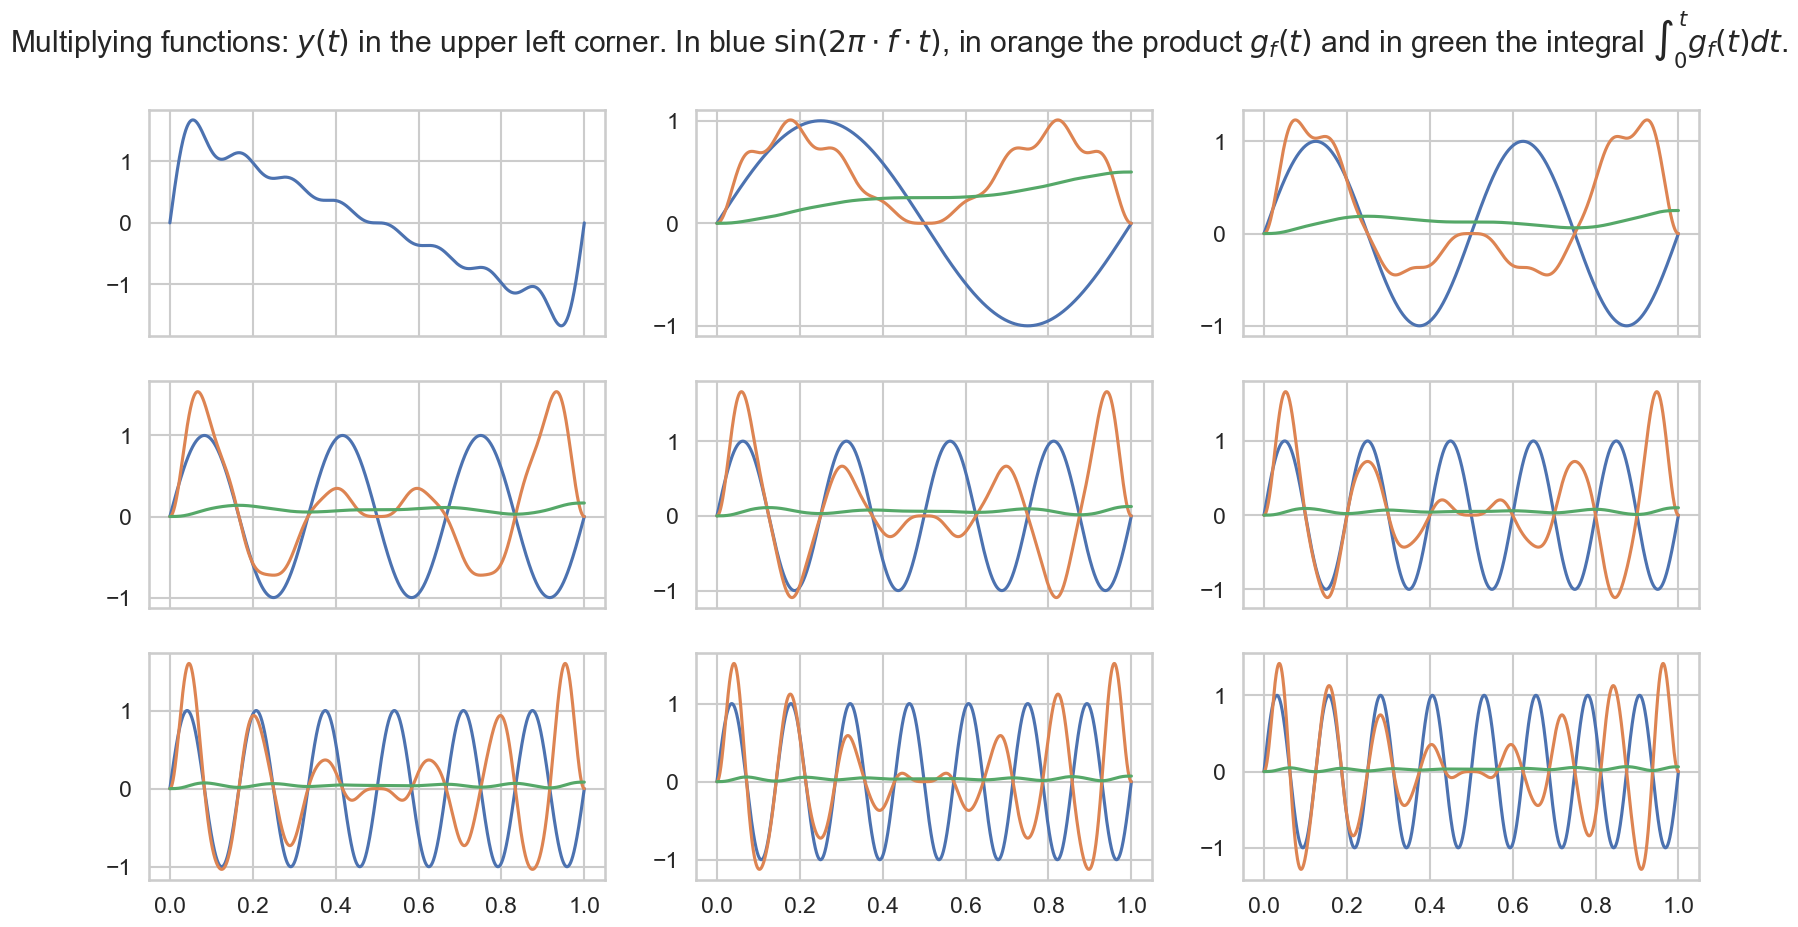

In [3]:
N = 100000
n = 8
def sawtooth_ap(t, n):
    result = 0
    for k in range(1, n+1, 1):
        result += np.sin(TWO_PI * k * t) / k
    return result
        
t = np.linspace(0, 1, N)
amp = sawtooth_ap(t, n)
k = int((n+1)**0.5)
fig, ax = plt.subplots(k,k,figsize=(20,10))
ax[0,0].plot(t, amp)

index = 0
for i in range(k):
    for j in range(k):
        if i < k-1:
            ax[i,j].set_xticklabels([])
        if i != 0 or j != 0:
            index += 1
            ax[i,j].plot(t, np.sin(TWO_PI * index * t))
            y=amp*np.sin(TWO_PI * index * t)
            ax[i,j].plot(t, y)
            ax[i,j].plot(t, cumtrapz(y=y, x=t, initial=0))
txt = fig.suptitle(r'Multiplying functions: $y(t)$ in the upper left corner. In blue $\sin(2\pi \cdot f \cdot t)$, in orange the product $g_f(t)$ and in green the integral $\int_{0}^t g_f(t) dt$.')

We get

$$\int_0^1 g_1(t)dt = \frac{1}{2}, \int_0^1 g_2(t)dt = \frac{1}{4}, \int_0^1 g_3(t)dt = \frac{1}{6}, \int_0^1 g_4(t)dt = \frac{1}{8}, \ldots$$

In general we get

```{math}
    \int_0^1 g_n(t)dt = \frac{1}{2n}.
```

Note that $\forall n \in \mathbb{N}:$

$$\int_0^1 \sin(2\pi \cdot n \cdot t)^2 dt = \frac{1}{2}$$

holds, thus

$$\int_0^1 \frac{1}{n}\sin(2\pi \cdot n \cdot t)^2 dt = \frac{1}{n} \int_0^1 \sin(2\pi \cdot n \cdot t)^2 dt = \frac{1}{2n}.$$

Therefore,

$$\int_0^1 g_n(t) dt = \frac{1}{n}\int_0^1 \sin(2\pi \cdot n \cdot t)^2 dt$$

follows.
If we look at the integral of 

$$h_n(t) = \left( y(t) - \frac{1}{n}\sin(2\pi \cdot n \cdot t) \right) \cdot \sin(2\pi \cdot n \cdot t),$$

then $\forall n \in \mathbb{N}:$

$$\int_0^1 h_n(t) dt = \int_{-\infty}^\infty h_n(t) dt = 0$$

holds.
In fact, if we look at $h_{i,j}(t) = \sin(2\pi i \cdot t ) \cdot \sin(2\pi j \cdot t)$ 

```{math}
:label: eq:perp:sines
\begin{split}
\forall i, j \in \mathbb{N}, i \neq j: \int_0^1 h_{i,j}(t) dt &= \int_{0}^1 h_{i,j}(t) dt = 0\\
&= \int_{-\infty}^\infty \sin(2\pi i \cdot t) \cdot \sin(2\pi j \cdot t ) dt\\
&= \int_{-\infty}^\infty h_{i,j}(t) dt
\end{split}
```

holds.

```{admonition} Perpendicular Functions
:name: theorem-perp-sine
:class: theorem

For all frequencies $i, j \in \mathbb{N}$ with $i \neq j$ 

$$\int_0^1 \sin(2\pi i \cdot t) \cdot \sin(2\pi j \cdot t ) dt = \int_{-\infty}^\infty \sin(2\pi i \cdot t) \cdot \sin(2\pi j \cdot t ) dt= 0$$

holds. We say that $\sin(2\pi i \cdot t)$ is *perpendicular* to $\sin(2\pi j \cdot t)$.
```

```isc
({ // generate sin(2*pi*i*x) * sin(2*pi*j*x)
    var sines = Array.fill(3, {arg i; 1/(i+1) * SinOsc.ar(i+1);});
    var y = Mix(sines);
    var indices = Array.fill2D(3, 3, {arg row, col; [row,col];}).flatten;
    indices.collect({arg index; var i = index[0], j = index[1];
        SinOsc.ar(i+1)*SinOsc.ar(j+1)
    });
}.plot(1)
)
```

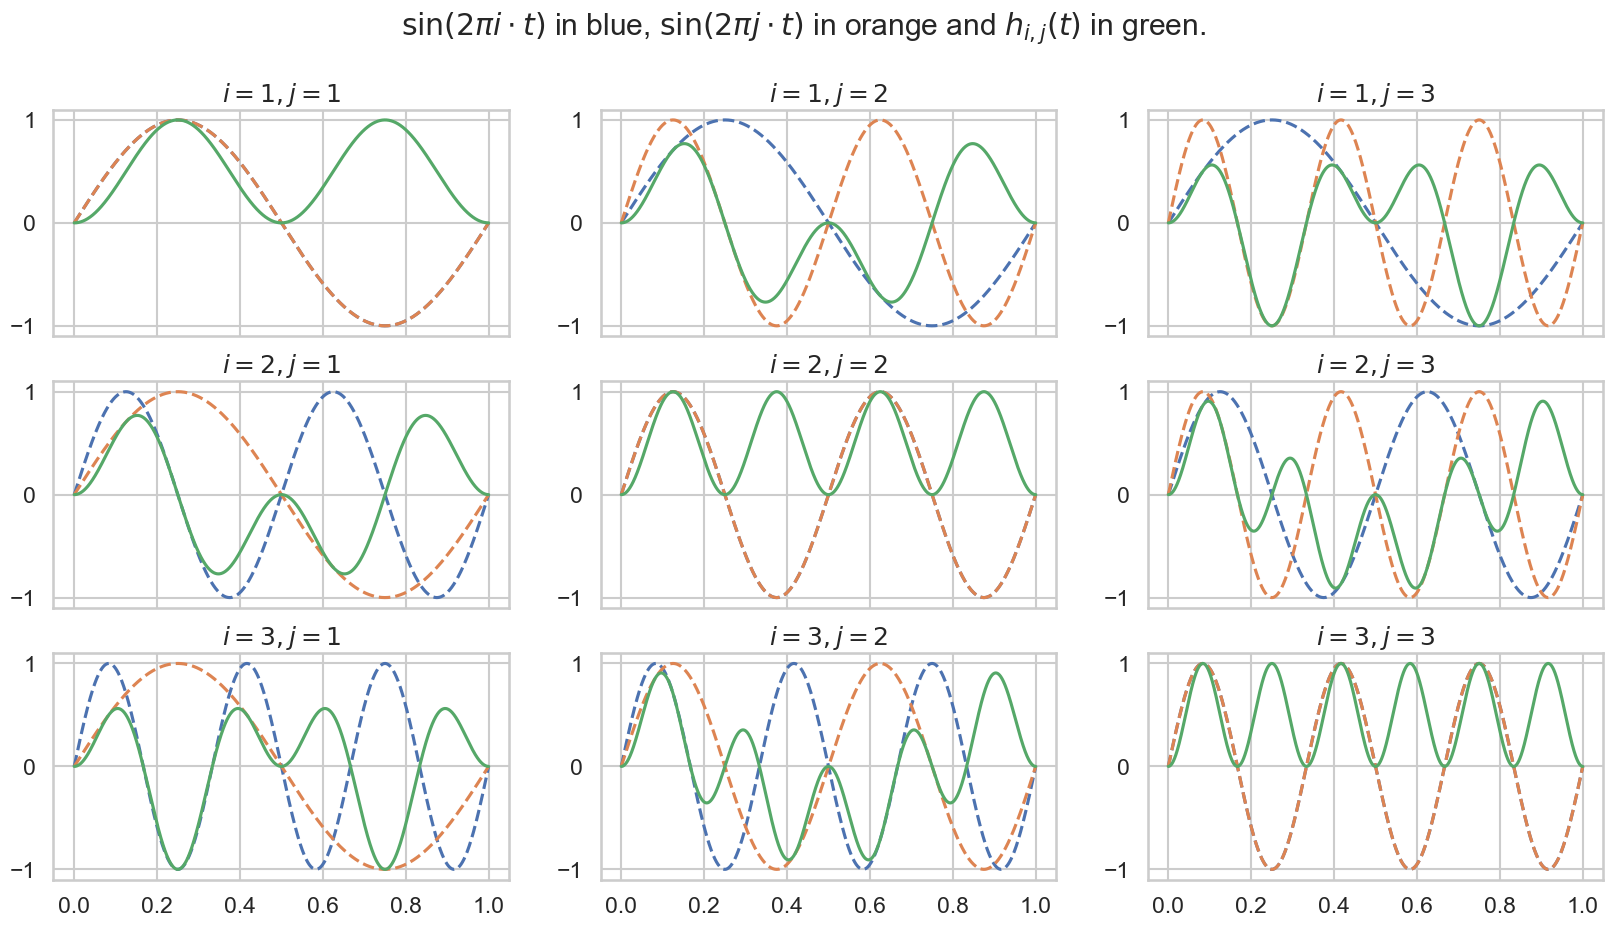

In [4]:
N = 100000
n = 8
        
t = np.linspace(0, 1, N)
k = int((n+1)**0.5)
fig, ax = plt.subplots(k,k,figsize=(20,10))

index = 0
for i in range(1,k+1):
    for j in range(1,k+1):
        index += 1
        alpha = 0
        beta = 0
        ax[i-1,j-1].plot(t, np.sin(TWO_PI * (i * t - alpha)), label=f'$i={{{i}}}$', linestyle='--')
        ax[i-1,j-1].plot(t, np.sin(TWO_PI * (j * t - beta)), label=f'$j={{{j}}}$', linestyle='--')
        ax[i-1,j-1].plot(t, np.sin(TWO_PI * (j * t - beta)) * np.sin(TWO_PI * (i * t - alpha)))
        if i < k:
            ax[i-1,j-1].set_xticklabels([])
        ax[i-1,j-1].set_title(f'$i={{{i}}}, j={{{j}}}$')
txt = fig.suptitle(r'$\sin(2\pi i \cdot t )$ in blue, $\sin(2\pi j \cdot t)$ in orange and $h_{i,j}(t)$ in green.')

We say that these functions are **perpendicular** to each other because their scalar product (the integral of their product) is zero!

One way to compare two vectors $\mathbf{a} = (a_1, \ldots, a_n)$ and $\mathbf{b} = (b_1, \ldots, b_n)$ is to compute their *inner product*.
If two vectors $\mathbf{a}, \mathbf{b}$ are perpendicular, i.e., if they are very different, their *inner product* 

$$<\mathbf{a}, \mathbf{b}> := \sum\limits_{i=1}^n a_i \cdot b_i$$

is zero.
Their inner product is large if they are similar.
We can define the inner product of two functions $h: \mathbb{R} \rightarrow \mathbb{R}$ and $g: \mathbb{R} \rightarrow \mathbb{R}$ in a similar fashion.
The sum changes to an integral.

````{admonition} Inner Product of two Functions
:name: def-scalar-product
:class: definition

Let $h: \mathbb{R} \rightarrow \mathbb{R}$ and $g: \mathbb{R} \rightarrow \mathbb{R}$ then 

```{math}
:label: eq:inner:product
    <h,g> := \int_{t \in \mathbb{R}} h(t)g(t) dt
```
is the inner product of $h$ and $g$.
````

## Fourier Analysis

Until know we assumed that all *phase shifts* are zero.
Then we concluded that if we compute the integral of signal $y(t)$ multiplied with a sinusoid of the same phase we get:

1. either $1/(2n)$, where $n \in \mathbb{N}$ is the **frequency** of the sinusoid (similarity)
2. or zero, in this case $y(t)$ is perpendicular to the sinusoid (non-similarity)

We can reformulate the problem of similarity using an optimization problem.
Let us start with an analog signal first $y(t)$.
And let us reconsider the *[Fourier series](def-fourier-series)*:

```{math}
y_N(t) = \frac{A_0}{2} + \sum\limits_{n=1}^N A_n \cdot \cos\left(\frac{2\pi \cdot n}{T}t - \phi_n\right)
```

We multiply some term of $y_N(t)$ with our signal and integrate it over the period of our signal:

$$X_n(\phi) = \frac{2}{T}\int_T y(t) \cdot \cos\left(\frac{2\pi \cdot n}{T}t - \phi_n\right) dt, \quad \phi \in [0;2\pi].$$

Following our discussion at the start of section [Similarity of Periodic Functions](sec-similarity-of-functions), at the maximum of $X_n(\phi)$ the integral is equal to the **amplitude** $A_n \cdot \frac{T}{2}$.
If the respective sinusoid is part of the *Fourier series* 

$$A_n = \max\limits_{\phi \in [0;T]} X_n(\phi)$$

is not zero, otherwise it is.
Therefore, we multiply the integral by $\frac{2}{T}$ to get $A_n$.
Furthermore, we get the missing **phase shift** defined by

$$\phi_n = \arg\max\limits_{\phi \in [0;T]} X_n(\phi)$$

Using the equivalence of polar and Cartesian forms, that is,

$$\cos\left(\frac{2\pi \cdot n}{T}t - \phi_n\right) \equiv \cos(\phi_n) \cdot \cos\left(\frac{2\pi \cdot n}{T}t \right) + \sin(\phi_n) \cdot \sin\left(\frac{2\pi \cdot n}{T}t \right)$$

We can simplify the $X(\phi)$:

\begin{equation*}
\begin{split}
X_n(\phi) &= \frac{2}{T}\int_T y(t) \cdot \cos\left(\frac{2\pi \cdot n}{T}t - \phi_n\right) dt\\
&= \cos(\phi) \cdot \frac{2}{T}\int_T y(t) \cdot \cos\left(\frac{2\pi \cdot n}{T}t \right)dt + \sin(\phi) \cdot \frac{2}{T}\int_T y(t) \cdot \sin\left(\frac{2\pi \cdot n}{T}t \right)dt\\
&= \cos(\phi) \cdot a_n + \sin(\phi) \cdot b_n
\end{split}
\end{equation*}

The derivative of $X_n(\phi)$ is zero at the **phase** of maximum correlation.
Threfore,

$$X'_n(\phi_n) = \sin(\phi_n) \cdot a_n - \cos(\phi_n) b_n = 0 \Rightarrow \tan(\phi_n) = \frac{b_n}{a_n}$$

holds and the correlation peak value is:

$$A_n = X_n(\phi_n) = \cos(\phi_n) a_n + \sin(\phi_n) b_n = \sqrt{a_n^2 + b_n^2}.$$

In other words, $a_n$ and $b_n$ are the *Cartesian coordinates* of a vector with *polar coordinates* $A_n$ and $\phi_n$.
That is quite remarkable.

If we use [Euler's formula](theorem-euler-formula), we can write the *Fourier series* in its exponential form.

````{admonition} Fourier Series (FS) in its Exponential Form
:name: def-fourier-series-exp
:class: definition

The *Foruier series* in *exponential form* $y_N(t)$ of a periodic function $y(t)$ is defined by

$$y_N(t) = \sum\limits_{n = -N}^N c_n \cdot e^{i2\pi n t / T}$$

where $N$ is potentially an infinite integer. 
$T$ is the period of $y(t)$, $A_n$ is the $n$-th hermonic's *amplitude*
$c_n$ is defined by

$$
c_n = \frac{1}{T} \int_T y(t) \cdot e^{-i2\pi n t / T} = \begin{cases} 
A_0/2 &= a_0 / 2 & \text{ if } n = 0\\
\frac{A_n}{2}e^{-i \phi_n} &= \frac{1}{2} (a_n - i b_n), & \text{ if } n > 0\\
\overline{c}_{|n|}, & & \text{ if } n < 0
\end{cases}
$$

This form generalizes to **complex-valued functions**.
````

Finally, we can define 

$$Y_N(n) = (A_n, \phi_n),$$

to be the tupel of amplitude $A_n$ and the **phase shift** $\phi_n$ of the respective sinusoid with **frequency** $n$ of the *Fourier series* of a (real) **periodic function** $y(t)$.

## Fourier Transform

*Fourier series* are limited to *periodic functions*.
Musical signals are mostly periodic but what if they are not?
Well, the *Fourier series* is used to represent a *periodic function* by a discrete sum of *complex exponentials*, while the *Fourier transform* is then used to represent a **general, non-periodic function** by a *continuous superposition* or *integral of complex exponentials*.
The *Fourier transform* can be viewed as the limit of the *Fourier series* of a function with the period approaches to infinity.
We switch from a *discrete superposition* to a *continuous superposition*.
Of course the *Fourier transform* can also deal with periodic functions.
Therefore, one might say that it is more powerful.

````{admonition} Fourier Transform (TF) (in its Exponential Form)
:name: def-fourier-transform-exp
:class: definition

the *Fourier transform* of an *integgrable* function $y : \mathbb{R} \rightarrow \mathbb{C}$ is defined by

```{math}
:label: eq:fourier:transform:exp
Y(f) = \int\limits_{-\infty}^\infty y(t) e^{-i2\pi f t} dt, \quad \forall f \in \mathbb{R}.
```

The transform of function $y(t)$ at frequency $f$ is given by the complex number $Y(f)$.

````

Evaluating $Y(f) \in \mathbb{C}$ for all values of $f$ produces the **frequency-domain** function.
The complex number $Y(f)$, conveys both **apmplitude** and **phase** of the **frequency** $f$.

Under suitable conditions $y(t)$ cen be represented as a recombination of *complex exponentials* of all possible frequencies:

$$y(t) = \int\limits_{-\infty}^\infty Y(f) e^{i2\pi f t} df, \quad \forall t \in \mathbb{R}.$$

The pair $(y, Y)$ are called *Fourier integral pair* or *Fourier transform pair*.

## The Discrete Fourier Transform

Up to this point, we considered continuous signals $y(t)$.
However, on a computer everything is digitalized, i.e. discretized.
Calling 

```isc
s.sampleRate // 44100 Hz
```

gives us the *sample rate* of our audio signals.
On my machine, I use a sample rate of 44100 Hz, i.e. 44100 samples per second.
Therefore, a audio signal $y$ represents 1 seconds by 44100 samples (rational numbers)

$$y[i], y[i+1], \ldots y[i+44099]$$

When the highest frequency of a signal is less than one-half of the sample rate, the resulting discrete-time sequence is said to be free of the distortion known as **aliasing** (different signals become indistinguishable to each other).
In other words, the sample rate has to more than double the highest frequncy of the sampled signal to avoid aliasing.

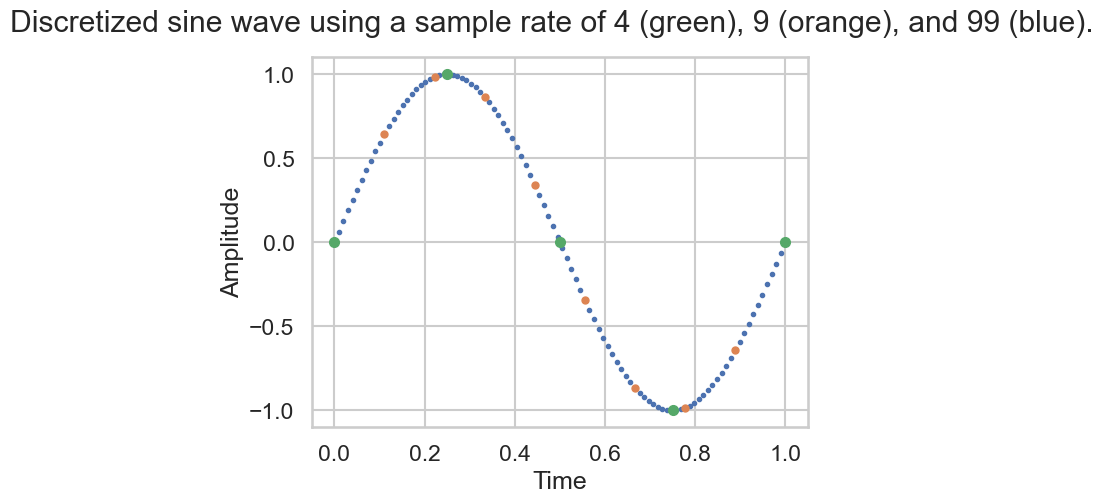

In [5]:
x1 = np.linspace(0, 1, 10)
y1 = np.sin(2*np.pi*x1)

x2 = np.linspace(0, 1, 5)
y2 = np.sin(2*np.pi*x2)

x3 = np.linspace(0, 1, 100)
y3 = np.sin(2*np.pi*x3)

fig, ax = lineplot(x3, y3, marker = 'o', ms=3.0, linestyle = 'None')
lineplot(x1, y1, fig=fig, ax=ax, marker = 'o', ms=5.0, linestyle = 'None')
lineplot(x2, y2, ax= ax, fig=fig, marker = 'o', ms=7.0, linestyle = 'None')
txt = fig.suptitle(r'Discretized sine wave using a sample rate of 4 (green), 9 (orange), and 99 (blue).')

To deal with a **periodic** and **discrete** signal we switch from the *Fourier transform* to the *discrete Fourier transform*.
Note that if we want to handle a **non-periodic** and **discrete** signal we apply the discrete-time Fourier transform*.

````{admonition} Discrete Fourier Series (DFS)
:name: def-fourier-series-exp-discrete
:class: definition

The *discrete Foruier series* $y_N[n]$ in *exponential form* of a periodic and discrete function $y[n]$ is defined by

$$y_N[n] = \sum\limits_{k=0}^{N-1} x[k] \cdot e^{i\frac{2\pi}{N}kn}, \quad n \in \mathbb{Z},$$

which are harmonics of a fundamental frequency $1/N$, for some positive integer $N$ (the period of the signal).
````

This looks very similar to the [Fourier series](def-fourier-series-exp) except that $e^{ikn\frac{2\pi}{N}}$ is a discrete instead of a continuous a function!
Instead of a sum of functions, the *discrete Fourier Series* is a sum of discrete functions.
Furthermore, there are only $N$ distinct coefficients $c_0, \ldots c_{N-1}$.
$y_n$ is periodic and so is $c_k$.

````{admonition} Discrete Fourier Transform (DFT) and its inverse (IDFT)
:name: def-fourier-transform
:class: definition

The *discrete Foruier transform (DFT)* transforms a sequence of $N$ *complex numbers* $y_N[0], \ldots, y_N[N-1]$ into another sequence of complex numbers $c[0], \ldots, c[N-1]$, which is defined by 

$$c[k] = \sum\limits_{n=0}^{N-1} y[n] \cdot e^{-i\frac{2\pi}{N}nk} = y[n] \cdot \left[ \cos\left( \frac{2\pi}{N}nk \right) -i \sin\left( \frac{2\pi}{N}nk \right) \right],$$

where $c[k]$ for $k = 0, \ldots, N-1$ are the coefficients of the *[discrete Fourier series](def-fourier-series-exp-discrete)*.

The DFT is an invertible, linear transformation.
Its inverse is known as *inverse discrete Fourier transform (IDFT)* given by 

$$y[n] = \frac{1}{N} \sum\limits_{k=0}^{N-1} c[k] \cdot e^{i\frac{2\pi}{N}kn}.$$

````

## Example

Suppose the following signal 

$$y(t) = \underbrace{5}_{\text{DC}} + \underbrace{2 \cos(2\pi t - \pi/2)}_{\text{1 Hz}} + \underbrace{3 \cdot \cos(4\pi t)}_{\text{2 Hz}}.$$

Let's sample $y(t)$ at 4 times per second, i.e. a *sample rate* $f_s$ of 4 Hz from $t = 0$ to $t=3/2$.
The values of the discrete samples are given by:

$$y[n] = 5 + 2 \cos(\pi/3 n - \pi/2) + 3 \cos(\pi n)$$

for $t = n / 4$.
We get $y[0] = 8$, $y[1] = 4$, $y[2] = 8$, $y[3] = 0$, $y[4] = y[0]$, ...
Clearly $N = 4$ since we have frequencies of 1 and 2 Hz and a sample frequency $f_s$ of 4 Hz.

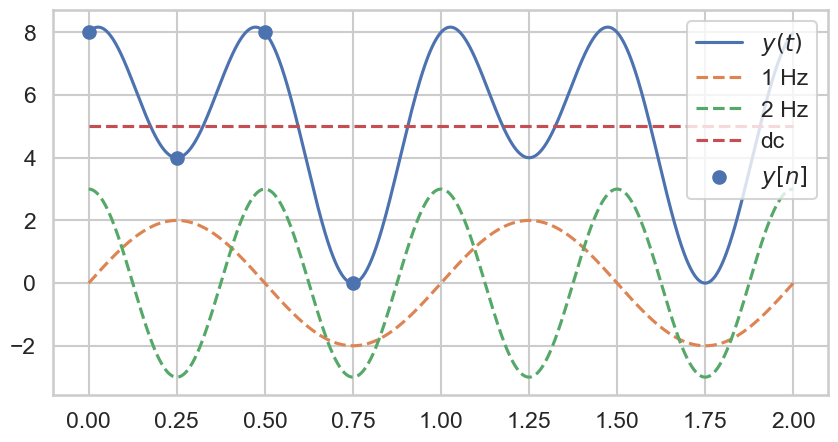

In [6]:
y1 = lambda t: 2 * np.cos(2*np.pi*t - np.pi/2)
y2 = lambda t: 3 * np.cos(4*np.pi*t)
dc = lambda t: np.ones(len(t))*5
y = lambda t: dc(t) + y1(t) + y2(t)

t = np.linspace(0, 2, 1000)
n = np.linspace(0, 1, 5)[:-1]
y_n = y(n)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t, y(t), label=r'$y(t)$')
ax.plot(t, y1(t), label=r'1 Hz', linestyle='--')
ax.plot(t, y2(t), label=r'2 Hz', linestyle='--')
ax.plot(t, dc(t), label=r'dc', linestyle='--')
ax.scatter(n, y_n, label=r'$y[n]$', marker='o')
fig = ax.legend()

In [7]:
def dft(y, k):
    N = len(y)
    result = 0
    for n in range(N):
        result += y[n] * np.exp(-1j * 2*np.pi/N * n * k)
    return result

def idft(c, n):
    N = len(c)
    result = 0
    for k in range(N):
        result += c[k] * np.exp(1j * 2*np.pi/N * k * n)
    return 1/N * result

In [8]:
c_k = [dft(y_n, k) for k in range(len(y_n))]
c_k

[(20+0j),
 -4.000000000000001j,
 (12+1.4695761589768238e-15j),
 (-8.881784197001252e-16+3.999999999999997j)]

``c_k`` contains the values of our coefficients, i.e. $c[k]$ for $k = 0, 1, 2, 3$ **Hz**.

Let's now apply the IDFT:

In [9]:
iy_n = [idft(c_k, n) for n in range(len(c_k))]
iy_n

[(8-6.661338147750939e-16j),
 (3.999999999999999-2.288475490443916e-17j),
 (8+6.661338147750939e-16j),
 (7.771561172376096e-16+1.247531554051792e-15j)]

If we neglect the small numerical errors, we get the correct function values $y[n]$ for $n = 0, 1, 2, 3$ back again.
The imaginary part of the complex numbers are approximately zero.